In [1]:
#Imports
import pandas as pd
import csv
from api_keys import census_api
import json
import requests
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter

In [2]:
#Input
traffic_data = "./Resources/US_Accidents_March23.csv"

In [3]:
traffic_df=pd.read_csv(traffic_data)
traffic_df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


In [4]:
#Creating DataFrame w/ reduced columns
reduced_traffic_df = traffic_df[["Start_Time","End_Time","Severity","City","State","Weather_Condition",
                                 "Temperature(F)","Visibility(mi)","Wind_Speed(mph)","Precipitation(in)",\
                                 "Sunrise_Sunset","Description","Bump","Crossing", "Give_Way","Junction",\
                                 "No_Exit","Railway","Roundabout","Station","Stop","Traffic_Calming",\
                                 "Traffic_Signal","Turning_Loop","Description"
                                ]]
reduced_traffic_df.shape

(7728394, 25)

In [5]:
#Using function to parse date and convert to strint
def parse_time(raw):
    date = dt.datetime.fromisoformat(raw).date()
    string = date.isoformat()
    return string

In [6]:
reduced_traffic_df.loc[:, "Start_Date"] = reduced_traffic_df['Start_Time'].map(parse_time)
reduced_traffic_df.loc[:, "End_Date"] = reduced_traffic_df['End_Time'].map(parse_time)

/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_5831/4217142928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "Start_Date"] = reduced_traffic_df['Start_Time'].map(parse_time)
/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_5831/4217142928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "End_Date"] = reduced_traffic_df['End_Time'].map(parse_time)


In [7]:
#using function to extract Year from date
def year(raw):
    year_string = raw[:4]
    year_integer = int(year_string)
    return year_integer  

In [8]:
reduced_traffic_df.loc[:, "Start_Year"] = reduced_traffic_df['Start_Date'].map(year)
reduced_traffic_df.loc[:, "End_Year"] = reduced_traffic_df['End_Date'].map(year)

/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_5831/3843608378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "Start_Year"] = reduced_traffic_df['Start_Date'].map(year)
/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_5831/3843608378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_traffic_df.loc[:, "End_Year"] = reduced_traffic_df['End_Date'].map(year)


In [9]:
#dropping NA from df
drop_traffic_df = reduced_traffic_df.dropna(how='any')
drop_traffic_df.shape

(5382749, 29)

In [10]:
#Using function to format the drop traffic dataframe
drop_traffic_df.loc[:, "Start_Date"] = drop_traffic_df['Start_Time'].map(parse_time)
drop_traffic_df.loc[:, "End_Date"] = drop_traffic_df['End_Time'].map(parse_time)
drop_traffic_df.loc[:, "Start_Year"] = drop_traffic_df['Start_Date'].map(year)
drop_traffic_df.loc[:, "End_Year"] = drop_traffic_df['End_Date'].map(year)
drop_traffic_df.shape

/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_5831/3689601372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_traffic_df.loc[:, "Start_Date"] = drop_traffic_df['Start_Time'].map(parse_time)
/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_5831/3689601372.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_traffic_df.loc[:, "End_Date"] = drop_traffic_df['End_Time'].map(parse_time)
/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_5831/3689601372.py:4: SettingWith

(5382749, 29)

In [11]:
#reorganizing columns
organized_traffic_df = reduced_traffic_df[["Start_Year","Start_Date","End_Year","End_Date","Start_Time","End_Time",\
                                        "Severity","City","State","Weather_Condition","Temperature(F)","Visibility(mi)",\
                                        "Wind_Speed(mph)","Precipitation(in)","Sunrise_Sunset","Description","Bump",\
                                        "Crossing", "Give_Way","Junction","No_Exit","Railway","Roundabout","Station",\
                                        "Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"]]
organized_traffic_df.head()

,Start_Year,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,2016,2016-02-08,2016,2016-02-08,2016-02-08 05:46:00,2016-02-08 11:00:00,3,Dayton,OH,Light Rain,...,False,False,False,False,False,False,False,False,False,False
1,2016,2016-02-08,2016,2016-02-08,2016-02-08 06:07:59,2016-02-08 06:37:59,2,Reynoldsburg,OH,Light Rain,...,False,False,False,False,False,False,False,False,False,False
2,2016,2016-02-08,2016,2016-02-08,2016-02-08 06:49:27,2016-02-08 07:19:27,2,Williamsburg,OH,Overcast,...,False,False,False,False,False,False,False,False,True,False
3,2016,2016-02-08,2016,2016-02-08,2016-02-08 07:23:34,2016-02-08 07:53:34,3,Dayton,OH,Mostly Cloudy,...,False,False,False,False,False,False,False,False,False,False
4,2016,2016-02-08,2016,2016-02-08,2016-02-08 07:39:07,2016-02-08 08:09:07,2,Dayton,OH,Mostly Cloudy,...,False,False,False,False,False,False,False,False,True,False


In [12]:
organized_traffic_gp = organized_traffic_df.groupby(["Start_Year"]).count()
organized_traffic_gp

,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
Start_Year,,,,,,,,,,,,,,,,,,,,,
2016,410821,410821,410821,410821,410821,410821,410794,410821,402264,404372,...,410821,410821,410821,410821,410821,410821,410821,410821,410821,410821
2017,718093,718093,718093,718093,718093,718093,718066,718093,700543,703703,...,718093,718093,718093,718093,718093,718093,718093,718093,718093,718093
2018,893426,893426,893426,893426,893426,893426,893416,893426,871904,875415,...,893426,893426,893426,893426,893426,893426,893426,893426,893426,893426
2019,954303,954303,954303,954303,954303,954303,954284,954303,936077,937178,...,954303,954303,954303,954303,954303,954303,954303,954303,954303,954303
2020,1178913,1178913,1178913,1178913,1178913,1178913,1178863,1178913,1148939,1147949,...,1178913,1178913,1178913,1178913,1178913,1178913,1178913,1178913,1178913,1178913
2021,1563753,1563753,1563753,1563753,1563753,1563753,1563700,1563753,1531440,1531731,...,1563753,1563753,1563753,1563753,1563753,1563753,1563753,1563753,1563753,1563753
2022,1762452,1762452,1762452,1762452,1762452,1762452,1762387,1762452,1723764,1723734,...,1762452,1762452,1762452,1762452,1762452,1762452,1762452,1762452,1762452,1762452
2023,246633,246633,246633,246633,246633,246633,246631,246633,240004,240459,...,246633,246633,246633,246633,246633,246633,246633,246633,246633,246633


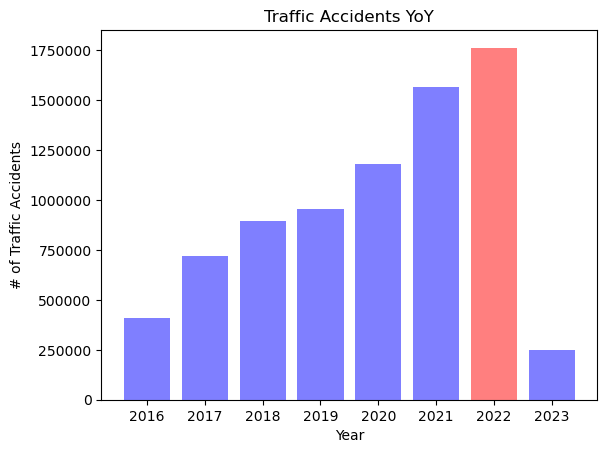

In [13]:
x_axis=organized_traffic_gp.index.tolist()
y_axis = organized_traffic_gp["State"].tolist()

plt.ticklabel_format(style='plain')
plt.bar(x_axis, y_axis,color=['b','b','b','b','b','b','r','b'],alpha=0.5, align="center")
plt.title("Traffic Accidents YoY")
plt.xlabel("Year")
plt.ylabel("# of Traffic Accidents")

plt.savefig("outputs/AccidentsYoY.png")
plt.show()

In [14]:
day_v_night = organized_traffic_df.groupby(["Start_Year","Sunrise_Sunset"]).count().reset_index()

day_series = day_v_night["Sunrise_Sunset"] == "Day"
night_series = day_v_night["Sunrise_Sunset"] == "Night"

In [15]:
day_df = day_v_night.loc[day_series]
day_count= day_df[["Start_Year","State"]]
day_count_r = day_count.rename(columns={"State":"Day_Count"})

night_df = day_v_night.loc[night_series]
night_count= night_df[["Start_Year","State"]]
night_count_r = night_count.rename(columns={"State":"Night_Count"})

day_night_df = pd.merge(night_count_r,day_count_r,on="Start_Year")

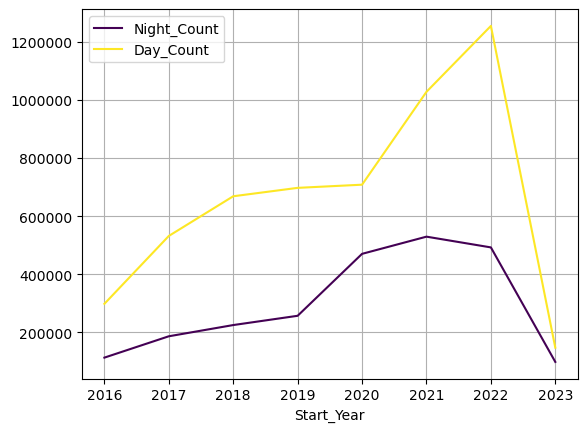

In [16]:
day_night_df.plot(x="Start_Year",kind="line",grid=True,colormap='viridis')
plt.ticklabel_format(style='plain')

plt.savefig("outputs/NigthtvDay.png")
plt.show()

In [17]:
#Adding total accidents to DF
total_accident = day_night_df[["Night_Count","Day_Count"]].sum(axis=1)
day_night_df["Total_Count"] = total_accident

In [18]:
#adding percentage of night v. day accidents
day_percent = (day_night_df["Day_Count"]/day_night_df["Total_Count"]) * 100
night_percent = (day_night_df["Night_Count"]/day_night_df["Total_Count"]) * 100

day_night_df["Night_Pct"] = night_percent
day_night_df["Day_Pct"] = day_percent

day_night_df

,Start_Year,Night_Count,Day_Count,Total_Count,Night_Pct,Day_Pct
0,2016,112742,298048,410790,27.445167,72.554833
1,2017,186263,531794,718057,25.939863,74.060137
2,2018,224905,668504,893409,25.173801,74.826199
3,2019,256833,697447,954280,26.913799,73.086201
4,2020,470174,708362,1178536,39.894751,60.105249
5,2021,529367,1028195,1557562,33.986897,66.013103
6,2022,492367,1255189,1747556,28.174605,71.825395
7,2023,97944,147014,244958,39.983997,60.016003


In [22]:
#Calling Census API
base_url = "https://api.census.gov/data/2021/acs/acs5?get=NAME,B01003_001E&for=place:*&in=state:*"
api_url = f"{base_url}&key={census_api}"
json_url = requests.get(api_url).json()
print(api_url)

https://api.census.gov/data/2021/acs/acs5?get=NAME,B01003_001E&for=place:*&in=state:*&key=9adc74e4cfc4d4a300ce521d201d867bcab7e31a


In [23]:
#Creating DataFrame from API
api_df = pd.DataFrame(json_url)
api_df

,0,1,2,3
0,NAME,B01003_001E,state,place
1,"Abanda CDP, Alabama",231,01,00100
2,"Abbeville city, Alabama",2231,01,00124
3,"Adamsville city, Alabama",4381,01,00460
4,"Addison town, Alabama",697,01,00484
...,...,...,...,...
31904,"Voladoras comunidad, Puerto Rico",696,72,87638
31905,"Yabucoa zona urbana, Puerto Rico",6466,72,87863
31906,"Yauco zona urbana, Puerto Rico",15404,72,88035
31907,"Yaurel comunidad, Puerto Rico",927,72,88121


In [24]:
#renaming column headers
api_df.columns=["City","Population","State #","Place #"]

In [25]:
#drop original column
drop = api_df.drop([0,0])

In [26]:
#Splitting City and State
split_cl = drop["City"].str.split(',',expand=True)

In [27]:
#Renaming Column Header
split_cl.columns=["City_1","State",""]
split_cl

,City_1,State,
1,Abanda CDP,Alabama,None
2,Abbeville city,Alabama,None
3,Adamsville city,Alabama,None
4,Addison town,Alabama,None
5,Akron town,Alabama,None
...,...,...,...
31904,Voladoras comunidad,Puerto Rico,None
31905,Yabucoa zona urbana,Puerto Rico,None
31906,Yauco zona urbana,Puerto Rico,None
31907,Yaurel comunidad,Puerto Rico,None


In [28]:
df =pd.concat([drop,split_cl],axis=1)
drop_df = df.drop([""],axis=1)
drop_df.head()

,City,Population,State #,Place #,City_1,State
1,"Abanda CDP, Alabama",231,01,00100,Abanda CDP,Alabama
2,"Abbeville city, Alabama",2231,01,00124,Abbeville city,Alabama
3,"Adamsville city, Alabama",4381,01,00460,Adamsville city,Alabama
4,"Addison town, Alabama",697,01,00484,Addison town,Alabama
5,"Akron town, Alabama",385,01,00676,Akron town,Alabama


In [29]:
#creating function to trim spaces
def trim(raw):
    trim = raw.strip()
    return trim

In [30]:
#Trimming space on State Column
drop_df["State"]= drop_df["State"].map(trim)

In [31]:
#renaming columns
census_rename_df = drop_df.rename(columns={"City":"City_State","City_1":"City"})
census_rename_df.head()

,City_State,Population,State #,Place #,City,State
1,"Abanda CDP, Alabama",231,01,00100,Abanda CDP,Alabama
2,"Abbeville city, Alabama",2231,01,00124,Abbeville city,Alabama
3,"Adamsville city, Alabama",4381,01,00460,Adamsville city,Alabama
4,"Addison town, Alabama",697,01,00484,Addison town,Alabama
5,"Akron town, Alabama",385,01,00676,Akron town,Alabama


In [32]:
#reordering columns
organized_census_df = census_rename_df[["City","State","Population","State #","Place #","City_State" 
]]
organized_census_df.head()

,City,State,Population,State #,Place #,City_State
1,Abanda CDP,Alabama,231,01,00100,"Abanda CDP, Alabama"
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama"
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama"
4,Addison town,Alabama,697,01,00484,"Addison town, Alabama"
5,Akron town,Alabama,385,01,00676,"Akron town, Alabama"


In [33]:
#Pulling City and excluding Puerto Rico
census_clean_df = organized_census_df[(organized_census_df["City"].str.contains("city")) \
                                      & (organized_census_df["State"] != "Puerto Rico")]
census_clean_df

,City,State,Population,State #,Place #,City_State
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama"
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama"
6,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama"
7,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama"
8,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama"
...,...,...,...,...,...,...
31572,Riverton city,Wyoming,10619,56,66220,"Riverton city, Wyoming"
31575,Rock Springs city,Wyoming,23505,56,67235,"Rock Springs city, Wyoming"
31580,Sheridan city,Wyoming,18660,56,69845,"Sheridan city, Wyoming"
31598,Torrington city,Wyoming,6196,56,77530,"Torrington city, Wyoming"


In [34]:
#converting population to integer
census_clean_df.loc[:,"Population"] = census_clean_df["Population"].astype(int)

/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_5831/243609777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_clean_df.loc[:,"Population"] = census_clean_df["Population"].astype(int)
/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_5831/243609777.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  census_clean_df.loc[:,"Population"] = census_clean_df["Population"].astype(int)


In [35]:
#Function to strip "city" from City
def strip(raw):
    city = raw.strip("city")
    trim = city.strip()
    return trim

In [36]:
census_clean_df.loc[:,"City2"] = census_clean_df["City"].map(strip)

/var/folders/nf/mdxt63n15r5_l8m95ry9byp40000gn/T/ipykernel_5831/3544217579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  census_clean_df.loc[:,"City2"] = census_clean_df["City"].map(strip)


In [37]:
city_rename = census_clean_df.rename(columns={"City": "City1","City2": "City"})
city_rename

,City1,State,Population,State #,Place #,City_State,City
2,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama",Abbeville
3,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama",Adamsville
6,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama",Alabaster
7,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama",Albertville
8,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama",Alexander City
...,...,...,...,...,...,...,...
31572,Riverton city,Wyoming,10619,56,66220,"Riverton city, Wyoming",Riverton
31575,Rock Springs city,Wyoming,23505,56,67235,"Rock Springs city, Wyoming",Rock Springs
31580,Sheridan city,Wyoming,18660,56,69845,"Sheridan city, Wyoming",Sheridan
31598,Torrington city,Wyoming,6196,56,77530,"Torrington city, Wyoming",Torrington


In [38]:
#importing City and State abbrev.
crosswalk_path = "Resources/crosswalk.csv"
state_abv = pd.read_csv(crosswalk_path)

In [39]:
#merging abbriviation data to census
crosswalk_state = pd.merge(city_rename,state_abv,on="State")

In [40]:
rename_cross = crosswalk_state.rename(columns={"State":"State_old","Abbreviation":"State"})
rename_cross.head()

,City1,State_old,Population,State #,Place #,City_State,City,State
0,Abbeville city,Alabama,2231,01,00124,"Abbeville city, Alabama",Abbeville,AL
1,Adamsville city,Alabama,4381,01,00460,"Adamsville city, Alabama",Adamsville,AL
2,Alabaster city,Alabama,33133,01,00820,"Alabaster city, Alabama",Alabaster,AL
3,Albertville city,Alabama,22268,01,00988,"Albertville city, Alabama",Albertville,AL
4,Alexander City city,Alabama,14765,01,01132,"Alexander City city, Alabama",Alexander City,AL


In [41]:
sorted_og_traffic = organized_traffic_df.sort_values(by=["State","City"],ascending=True)
sorted_og_traffic.head()

,Start_Year,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,City,State,Weather_Condition,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
523666,2022,2022-08-27,2022,2022-08-27,2022-08-27 14:47:41,2022-08-27 15:17:20,2,Abbeville,AL,Thunder in the Vicinity,...,True,False,False,False,False,False,False,False,False,False
530035,2022,2022-08-20,2022,2022-08-20,2022-08-20 16:32:02,2022-08-20 17:01:44,2,Abbeville,AL,Fair,...,False,False,False,False,False,False,False,False,False,False
536021,2022,2022-08-12,2022,2022-08-12,2022-08-12 20:30:17,2022-08-12 21:19:12,1,Abbeville,AL,Fair,...,True,False,False,False,False,False,False,False,False,False
548951,2022,2022-07-29,2022,2022-07-29,2022-07-29 06:38:49,2022-07-29 07:38:24,2,Abbeville,AL,Mostly Cloudy,...,False,False,False,False,False,False,False,False,False,False
557220,2022,2022-07-20,2022,2022-07-20,2022-07-20 12:57:22,2022-07-20 13:40:00,2,Abbeville,AL,Partly Cloudy,...,False,False,False,False,False,False,False,False,False,False


In [42]:
state_accidents = sorted_og_traffic.groupby(["Start_Year","State","City"]).count()

In [43]:
#resetting index on state_accidents
clean_reset_df = state_accidents.reset_index()
clean_reset_df

,Start_Year,State,City,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,Weather_Condition,...,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop
0,2016,AL,Ashville,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2016,AL,Athens,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2016,AL,Atmore,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,2016,AL,Attalla,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,2016,AL,Auburn,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97722,2023,WY,Rock Springs,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
97723,2023,WY,Sinclair,36,36,36,36,36,36,33,...,36,36,36,36,36,36,36,36,36,36
97724,2023,WY,Wamsutter,77,77,77,77,77,77,29,...,77,77,77,77,77,77,77,77,77,77
97725,2023,WY,Wheatland,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16


In [44]:
#merging Census and City Traffic data
state_city_accident_census = pd.merge(clean_reset_df,rename_cross,on=["State","City"],how="inner")
state_city_accident_census

,Start_Year,State,City,Start_Date,End_Year,End_Date,Start_Time,End_Time,Severity,Weather_Condition,...,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,City1,State_old,Population,State #,Place #,City_State
0,2016,AL,Ashville,1,1,1,1,1,1,1,...,1,1,1,1,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
1,2018,AL,Ashville,11,11,11,11,11,11,11,...,11,11,11,11,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
2,2019,AL,Ashville,8,8,8,8,8,8,8,...,8,8,8,8,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
3,2020,AL,Ashville,7,7,7,7,7,7,7,...,7,7,7,7,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
4,2021,AL,Ashville,18,18,18,18,18,18,15,...,18,18,18,18,Ashville city,Alabama,2096,01,02908,"Ashville city, Alabama"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36919,2023,TX,Talco,1,1,1,1,1,1,1,...,1,1,1,1,Talco city,Texas,577,48,71732,"Talco city, Texas"
36920,2023,TX,Trenton,3,3,3,3,3,3,3,...,3,3,3,3,Trenton city,Texas,729,48,73592,"Trenton city, Texas"
36921,2023,WV,Follansbee,1,1,1,1,1,1,1,...,1,1,1,1,Follansbee city,West Virginia,2842,54,28204,"Follansbee city, West Virginia"
36922,2023,WV,McMechen,1,1,1,1,1,1,1,...,1,1,1,1,McMechen city,West Virginia,1667,54,50260,"McMechen city, West Virginia"


In [45]:
#simplifying columns
city_accident_census = state_city_accident_census[["State","City","Start_Year","Population","Start_Date"]]
city_accident_census.head()

,State,City,Start_Year,Population,Start_Date
0,AL,Ashville,2016,2096,1
1,AL,Ashville,2018,2096,11
2,AL,Ashville,2019,2096,8
3,AL,Ashville,2020,2096,7
4,AL,Ashville,2021,2096,18


In [46]:
#merging census and traffic data
census_traffic_df = pd.merge(reduced_traffic_df,rename_cross,on=["State","City"],how="inner")
census_traffic_df.head()

,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Start_Date,End_Date,Start_Year,End_Year,City1,State_old,Population,State #,Place #,City_State
0,2016-02-08 05:46:00,2016-02-08 11:00:00,3,Dayton,OH,Light Rain,36.9,10.0,NaN,0.02,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
1,2016-02-08 07:23:34,2016-02-08 07:53:34,3,Dayton,OH,Mostly Cloudy,35.1,9.0,4.6,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
2,2016-02-08 07:39:07,2016-02-08 08:09:07,2,Dayton,OH,Mostly Cloudy,36.0,6.0,3.5,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
3,2016-02-08 07:59:35,2016-02-08 08:29:35,2,Dayton,OH,Overcast,34.0,7.0,3.5,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
4,2016-02-08 07:59:58,2016-02-08 08:29:58,3,Dayton,OH,Overcast,34.0,7.0,3.5,NaN,...,2016-02-08,2016-02-08,2016,2016,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"


In [47]:
#renaming colums
census_accidents_pop =city_accident_census.rename(columns={"Start_Date":"Accidents"})
census_accidents_pop

,State,City,Start_Year,Population,Accidents
0,AL,Ashville,2016,2096,1
1,AL,Ashville,2018,2096,11
2,AL,Ashville,2019,2096,8
3,AL,Ashville,2020,2096,7
4,AL,Ashville,2021,2096,18
...,...,...,...,...,...
36919,TX,Talco,2023,577,1
36920,TX,Trenton,2023,729,3
36921,WV,Follansbee,2023,2842,1
36922,WV,McMechen,2023,1667,1


In [48]:
#Population per 100K
census_accidents_pop["pop_per_100K"] = census_accidents_pop["Population"]/100000
census_accidents_pop

,State,City,Start_Year,Population,Accidents,pop_per_100K
0,AL,Ashville,2016,2096,1,0.02096
1,AL,Ashville,2018,2096,11,0.02096
2,AL,Ashville,2019,2096,8,0.02096
3,AL,Ashville,2020,2096,7,0.02096
4,AL,Ashville,2021,2096,18,0.02096
...,...,...,...,...,...,...
36919,TX,Talco,2023,577,1,0.00577
36920,TX,Trenton,2023,729,3,0.00729
36921,WV,Follansbee,2023,2842,1,0.02842
36922,WV,McMechen,2023,1667,1,0.01667


In [49]:
#accidents per 100K population
census_accidents_pop["accidents_per_pop_100K"] = census_accidents_pop["Accidents"] / census_accidents_pop["pop_per_100K"]
census_accidents_pop

,State,City,Start_Year,Population,Accidents,pop_per_100K,accidents_per_pop_100K
0,AL,Ashville,2016,2096,1,0.02096,47.709924
1,AL,Ashville,2018,2096,11,0.02096,524.809160
2,AL,Ashville,2019,2096,8,0.02096,381.679389
3,AL,Ashville,2020,2096,7,0.02096,333.969466
4,AL,Ashville,2021,2096,18,0.02096,858.778626
...,...,...,...,...,...,...,...
36919,TX,Talco,2023,577,1,0.00577,173.310225
36920,TX,Trenton,2023,729,3,0.00729,411.522634
36921,WV,Follansbee,2023,2842,1,0.02842,35.186488
36922,WV,McMechen,2023,1667,1,0.01667,59.988002


In [50]:
#fitering on population >100K
major_cities = census_accidents_pop[census_accidents_pop["Population"]>=100000]

In [51]:
major_cities.sort_values(by=["accidents_per_pop_100K"],ascending=False)

,State,City,Start_Year,Population,Accidents,pop_per_100K,accidents_per_pop_100K
5112,FL,Miami,2022,440807,64505,4.40807,14633.388308
5111,FL,Miami,2021,440807,58816,4.40807,13342.800818
5317,FL,Orlando,2022,302968,36402,3.02968,12015.130311
5316,FL,Orlando,2021,302968,33014,3.02968,10896.860394
11119,LA,Baton Rouge,2021,225539,14552,2.25539,6452.099193
...,...,...,...,...,...,...,...
20377,TX,Amarillo,2016,200371,1,2.00371,0.499074
264,AR,Little Rock,2016,201893,1,2.01893,0.495312
31833,FL,Port St. Lucie,2018,202177,1,2.02177,0.494616
30516,TX,Lubbock,2023,255537,1,2.55537,0.391333


In [52]:
accidents_per_pop = (major_cities["Accidents"]/major_cities["Population"])

In [53]:
accident_by_city = major_cities.groupby(["Start_Year","State","City"])

accident_df = accident_by_city.first()
#accident_by_city.apply(display)
#accident_by_city.get_group((2022,"FL","Miami"))

In [54]:
accident_df.reset_index()

,Start_Year,State,City,Population,Accidents,pop_per_100K,accidents_per_pop_100K
0,2016,AL,Birmingham,202234,28,2.02234,13.845347
1,2016,AL,Mobile,187445,7,1.87445,3.734429
2,2016,AL,Montgomery,201022,13,2.01022,6.466954
3,2016,AR,Little Rock,201893,1,2.01893,0.495312
4,2016,AZ,Chandler,272439,85,2.72439,31.199645
...,...,...,...,...,...,...,...
2322,2023,WA,Tacoma,217332,149,2.17332,68.558703
2323,2023,WA,Vancouver,188331,88,1.88331,46.726243
2324,2023,WI,Green Bay,107083,59,1.07083,55.097448
2325,2023,WI,Madison,265447,188,2.65447,70.823931


In [ ]:
####Question: What were the impact of weather changes on traffic accidents?

#### Aspen Jack


In [55]:
census_traffic_df.dtypes

Start_Time            object
End_Time              object
Severity               int64
City                  object
State                 object
Weather_Condition     object
Temperature(F)       float64
Visibility(mi)       float64
Wind_Speed(mph)      float64
Precipitation(in)    float64
Sunrise_Sunset        object
Description           object
Bump                    bool
Crossing                bool
Give_Way                bool
Junction                bool
No_Exit                 bool
Railway                 bool
Roundabout              bool
Station                 bool
Stop                    bool
Traffic_Calming         bool
Traffic_Signal          bool
Turning_Loop            bool
Description           object
Start_Date            object
End_Date              object
Start_Year             int64
End_Year               int64
City1                 object
State_old             object
Population             int64
State #               object
Place #               object
City_State    

In [58]:
#Filter DataFrame for year 2022
census_2022 = census_traffic_df.loc[census_traffic_df["Start_Year"] == 2022]
census_2022

,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Start_Date,End_Date,Start_Year,End_Year,City1,State_old,Population,State #,Place #,City_State
5684,2022-09-08 14:28:57,2022-09-08 15:18:00,3,Dayton,OH,Partly Cloudy,78.0,10.00,7.0,0.0,...,2022-09-08,2022-09-08,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5685,2022-09-08 06:57:05,2022-09-08 07:26:51,1,Dayton,OH,Fair,56.0,10.00,3.0,0.0,...,2022-09-08,2022-09-08,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5686,2022-09-07 16:01:45,2022-09-07 16:45:39,3,Dayton,OH,Partly Cloudy,78.0,10.00,10.0,0.0,...,2022-09-07,2022-09-07,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5687,2022-09-07 08:01:51,2022-09-07 09:01:47,3,Dayton,OH,Cloudy,63.0,5.00,3.0,0.0,...,2022-09-07,2022-09-07,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5688,2022-09-06 18:07:54,2022-09-06 18:56:00,3,Dayton,OH,Cloudy,75.0,10.00,13.0,0.0,...,2022-09-06,2022-09-06,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5544703,2022-07-24 18:47:08.000000000,2022-07-24 20:03:08.000000000,2,McGregor,TX,Fair,101.0,10.00,13.0,0.0,...,2022-07-24,2022-07-24,2022,2022,McGregor city,Texas,5345,48,45672,"McGregor city, Texas"
5544704,2022-07-12 16:17:00,2022-07-12 21:02:00,2,Burkesville,KY,Heavy Rain / Windy,73.0,1.00,22.0,0.0,...,2022-07-12,2022-07-12,2022,2022,Burkesville city,Kentucky,1470,21,11098,"Burkesville city, Kentucky"
5544705,2022-12-21 13:15:02.000000000,2022-12-21 16:36:00.000000000,2,Box Elder,SD,Blowing Snow / Windy,-11.0,0.12,30.0,0.0,...,2022-12-21,2022-12-21,2022,2022,Box Elder city,South Dakota,11527,46,06620,"Box Elder city, South Dakota"
5544706,2022-12-31 13:46:59.000000000,2022-12-31 15:47:31.000000000,2,Dovray,MN,NaN,NaN,NaN,NaN,NaN,...,2022-12-31,2022-12-31,2022,2022,Dovray city,Minnesota,48,27,16300,"Dovray city, Minnesota"


In [59]:
#Filter DataFrame further to cities with population over 100k
census_100k_2022 = census_2022.loc[census_2022["Population"] > 100000]
census_100k_2022

,Start_Time,End_Time,Severity,City,State,Weather_Condition,Temperature(F),Visibility(mi),Wind_Speed(mph),Precipitation(in),...,Start_Date,End_Date,Start_Year,End_Year,City1,State_old,Population,State #,Place #,City_State
5684,2022-09-08 14:28:57,2022-09-08 15:18:00,3,Dayton,OH,Partly Cloudy,78.0,10.0,7.0,0.0,...,2022-09-08,2022-09-08,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5685,2022-09-08 06:57:05,2022-09-08 07:26:51,1,Dayton,OH,Fair,56.0,10.0,3.0,0.0,...,2022-09-08,2022-09-08,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5686,2022-09-07 16:01:45,2022-09-07 16:45:39,3,Dayton,OH,Partly Cloudy,78.0,10.0,10.0,0.0,...,2022-09-07,2022-09-07,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5687,2022-09-07 08:01:51,2022-09-07 09:01:47,3,Dayton,OH,Cloudy,63.0,5.0,3.0,0.0,...,2022-09-07,2022-09-07,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
5688,2022-09-06 18:07:54,2022-09-06 18:56:00,3,Dayton,OH,Cloudy,75.0,10.0,13.0,0.0,...,2022-09-06,2022-09-06,2022,2022,Dayton city,Ohio,138416,39,21000,"Dayton city, Ohio"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5478722,2022-12-28 20:35:30.000000000,2022-12-29 00:02:25.000000000,2,Gresham,OR,Cloudy,45.0,10.0,6.0,0.0,...,2022-12-28,2022-12-29,2022,2022,Gresham city,Oregon,114164,41,31250,"Gresham city, Oregon"
5478723,2022-12-28 20:40:44,2022-12-28 21:55:44,2,Gresham,OR,Cloudy,45.0,10.0,6.0,0.0,...,2022-12-28,2022-12-28,2022,2022,Gresham city,Oregon,114164,41,31250,"Gresham city, Oregon"
5478724,2022-12-28 20:35:30,2022-12-29 00:02:25,2,Gresham,OR,Cloudy,45.0,10.0,6.0,0.0,...,2022-12-28,2022-12-29,2022,2022,Gresham city,Oregon,114164,41,31250,"Gresham city, Oregon"
5478725,2022-12-28 20:35:30.000000,2022-12-28 22:48:30.000000,2,Gresham,OR,Cloudy,45.0,10.0,6.0,0.0,...,2022-12-28,2022-12-28,2022,2022,Gresham city,Oregon,114164,41,31250,"Gresham city, Oregon"


In [87]:
#Set variables
#temp_counts = census_100k_2022.groupby(["Temperature(F)"]).count()
#temp_counts
temp_counts = census_100k_2022["Temperature(F)"].value_counts()

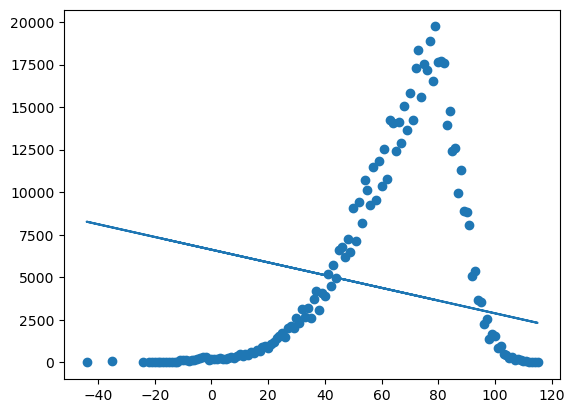

-0.2619966265625723


In [96]:
#temp = temp_counts["Temperature(F)"]

plt.scatter(temp_counts.index, temp_counts)
ta_slope, ta_int, ta_r, ta_p, ta_std_err = linregress(temp_counts.index, accident_count)
ta_fit = ta_slope * temp_counts.index + ta_int
plt.plot(temp_counts.index, ta_fit)
plt.show()
print(ta_r)

<BarContainer object of 141 artists>

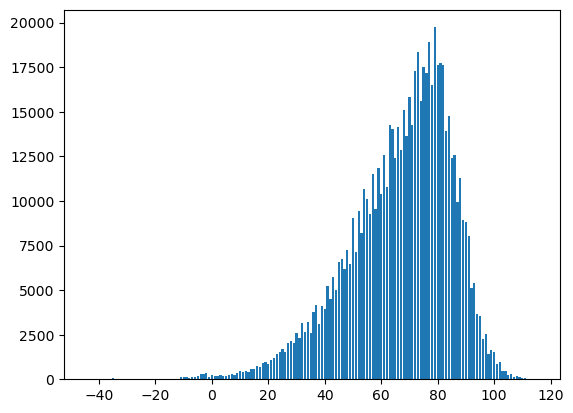

In [97]:
plt.bar(temp_counts.index, temp_counts)

In [75]:
accident_count = temp_counts["Start_Time"]
accident_count

Temperature(F)
-44.0      1
-35.0     61
-24.0      1
-22.0      1
-21.0      3
          ..
 111.0    65
 112.0    13
 113.0    18
 114.0    10
 115.0     5
Name: Start_Time, Length: 141, dtype: int64

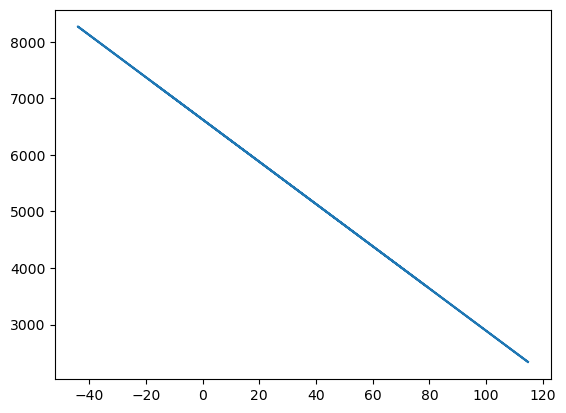

In [94]:
#Calculate linear regression model for scatter plot 
ta_slope, ta_int, ta_r, ta_p, ta_std_err = linregress(temp_counts.index, accident_count)
ta_fit = ta_slope * temp_counts.index + ta_int
#Plot and label scatter plot again
#plt.scatter(capomulin_mean["Weight (g)"], capomulin_mean["Tumor Volume (mm3)"])
#plt.xlabel("Weight (g)")
#plt.ylabel("Average Tumor Volume (mm3)")
#plt.title("Average Tumor Volume vs. Mouse Weight for Capomulin Treatment")
#Plot linear regression on top of scatter plot
plt.plot(temp_counts.index, ta_fit)
#Display
plt.show()

In [108]:
top_wx = census_100k_2022["Weather_Condition"].value_counts().head(10)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Fair'),
  Text(1, 0, 'Mostly Cloudy'),
  Text(2, 0, 'Cloudy'),
  Text(3, 0, 'Partly Cloudy'),
  Text(4, 0, 'Light Rain'),
  Text(5, 0, 'Light Snow'),
  Text(6, 0, 'Fog'),
  Text(7, 0, 'Rain'),
  Text(8, 0, 'Fair / Windy'),
  Text(9, 0, 'Haze')])

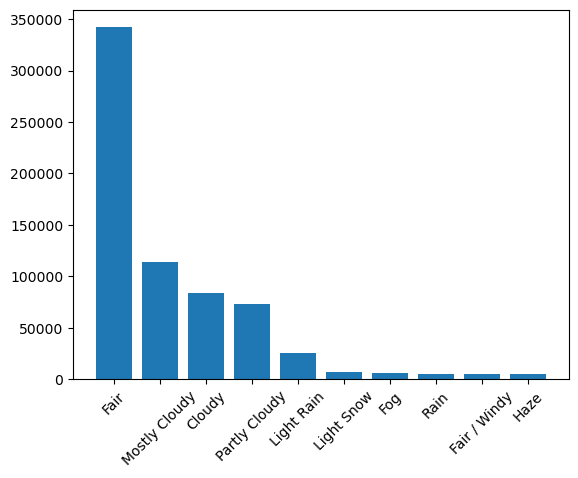

In [114]:
plt.bar(top_wx.index, top_wx)
plt.xticks(rotation=45)